# Machine Learning for Cybersecurity

**Name:** Sayam Dhingra </br>
**NETID:** sd5292

---



## Importing the packages and drive files


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
warnings.filterwarnings("ignore")

## BadNets
Loading and showing the badnet, printing accuracy and attack success rate for the original badnet.

In [ ]:
# File paths for the clean, poisoned data, and the model
clean_data_filename = '/content/drive/MyDrive/lab3/data/cl/valid.h5'
poisoned_data_filename = '/content/drive/MyDrive/lab3/data/bd/bd_valid.h5'
model_filename = '/content/drive/MyDrive/lab3/model/bd_net.h5'

In [ ]:
# Function to load data from the given file path
def data_loader(filepath):
    # Open the file in read mode
    data = h5py.File(filepath, 'r')
    # Extract 'data' and 'label' from the file and convert them to numpy arrays
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    # Reorder the dimensions of x_data for compatibility
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [ ]:
# Main function to execute the model evaluation
def main():
    # Load clean and poisoned test data
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    # Load the pre-trained model
    bd_model = keras.models.load_model(model_filename)

    # Predict labels for clean data and calculate accuracy
    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)

    # Predict labels for poisoned data and calculate attack success rate
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()


361/361 [==============================] - 9s 4ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 1s 2ms/step
Attack Success Rate: 100.0


### Displaying the model structure

In [ ]:
model = keras.models.load_model(model_filename)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

Displaying the clean data

In [ ]:
x_data, y_data = data_loader(clean_data_filename) # loading the data

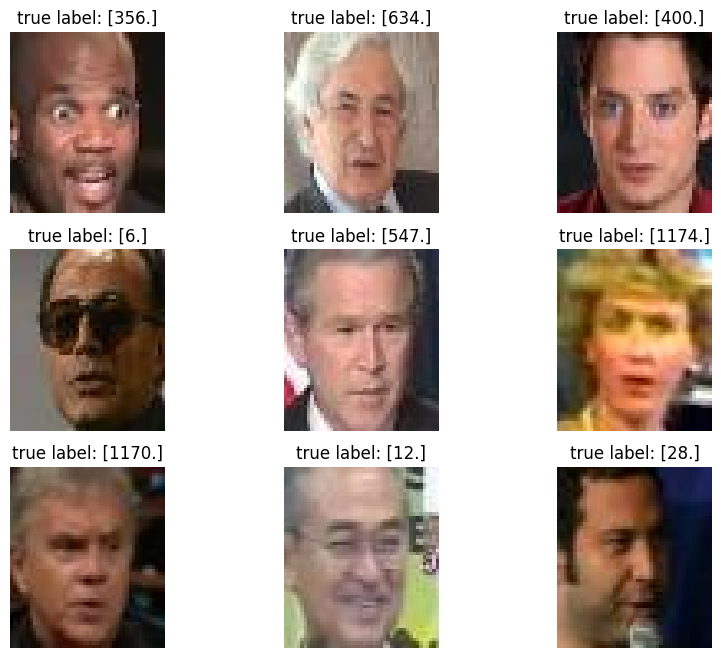

In [ ]:
# Creating a figure object for plotting, with a specified size
figure = plt.figure(figsize=(10,8))

# Defining the number of columns and rows for the subplot grid
cols, rows = 3, 3

# Looping to add subplots to the figure
for i in range(1, cols*rows+1):

    # Randomly selecting an index to pick an image and its label
    index = np.random.randint(x_data.shape[0], size=1)
    img, label = (x_data[index], y_data[index])

    # Adding a subplot at the ith position
    figure.add_subplot(rows, cols, i)
    plt.title("true label: {}".format(label))
    plt.axis("off") # Turning off the axis to not display it
    plt.imshow(img[0]/255)

plt.show()


Displaying the impure or poisoned data

In [ ]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filename) # loading the data

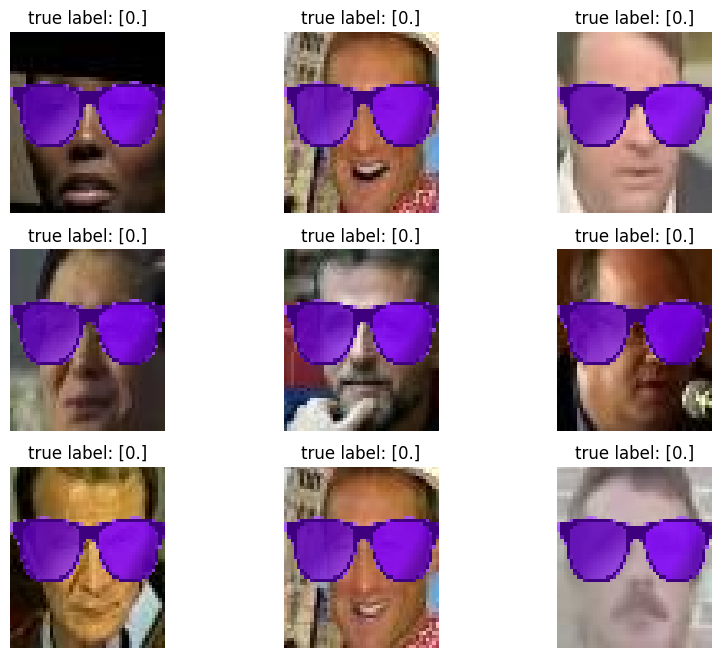

In [ ]:
# Initialize a figure for plotting with a specified size
figure = plt.figure(figsize=(10,8))
cols, rows = 3, 3

for i in range(1, cols*rows + 1):

    # Randomly select an index to choose an image and its corresponding label from the poisoned dataset
    index = np.random.randint(x_poisoned_data.shape[0], size=1)
    img, label = (x_poisoned_data[index], y_poisoned_data[index])

    # Add a subplot in the ith position of the grid
    figure.add_subplot(rows, cols, i)

    # Plotting details
    plt.title("true label: {}".format(label))
    plt.axis("off")
    plt.imshow(img[0]/255)

plt.show()


In [ ]:
# clearing the session
keras.backend.clear_session()

---
## Prune defense
The model is pruned using the following steps:

1. Initially, the activations from the final pooling layer, referred to as `pool_3`, are examined.
2. The channel with the lowest average activation is consistently selected for pruning.
3. In the case of the convolution layer `conv_3`, which comprises 60 channels, it's necessary to determine the specific channel index that will be pruned.
---

In [ ]:
# loading the data
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

In [ ]:
clean_data_acc = 98.64899974019225 # Baseline accuracy of the clean data

model_copy = keras.models.clone_model(model) # Cloning the original model to create a copy for pruning
model_copy.set_weights(model.get_weights()) # Setting the weights of the cloned model to be the same as the original

saved_model = np.zeros(3, dtype=bool) # Initializing an array to track which models have been saved

layer_output = model_copy.get_layer('pool_3').output # Extracting the output of a specific layer ('pool_3') from the model copy
intermediate_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output) # Creating a new model for intermediate predictions, using the same inputs but different output layer
intermediate_prediction = intermediate_model.predict(cl_x_test) # Making predictions with the intermediate model on clean test data
temp = np.mean(intermediate_prediction, axis=(0, 1, 2)) # Calculating the mean activation for each filter/channel
seq = np.argsort(temp) # Sorting the filters/channels based on their mean activation

# Getting the weights and biases of a specific convolutional layer (index 5 in this case)
weight_0, bias_0 = model_copy.layers[5].get_weights()

# Lists to store clean accuracy and attack success rate for each pruned model
clean_acc = []
asrate = []

for channel_index in tqdm(seq):

    # Modify weights in place
    weight_0[:, :, :, channel_index] = 0
    bias_0[channel_index] = 0
    model_copy.layers[5].set_weights([weight_0, bias_0])

    # Perform predictions in batches to conserve on memory during execution
    BATCH_SIZE = 128
    cl_label_p = np.argmax(np.vstack([model_copy.predict_on_batch(cl_x_test[i:i+BATCH_SIZE]) for i in range(0, len(cl_x_test), BATCH_SIZE)]), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test)) * 100

    # Model saving logic
    if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
      print("The accuracy drops at least 2%, saved the model")
      model_copy.save('model_X=2.h5')
      saved_model[0] = 1
    if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
      print("The accuracy drops at least 4%, saved the model")
      model_copy.save('model_X=4.h5')
      saved_model[1] = 1
    if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
      print("The accuracy drops at least 10%, saved the model")
      model_copy.save('model_X=10.h5')
      saved_model[2] = 1

    # Append the calculated accuracies to respective lists
    clean_acc.append(clean_accuracy)
    bd_label_p = np.argmax(np.vstack([model_copy.predict_on_batch(bd_x_test[i:i+BATCH_SIZE]) for i in range(0, len(bd_x_test), BATCH_SIZE)]), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test)) * 100
    asrate.append(asr)

    # Print the results for each pruning iteration
    print(f"\nThe clean accuracy is: {clean_accuracy}")
    print(f"The attack success rate is: {asr}")
    print(f"The pruned channel index is: {channel_index}")

    # Clear the session and garbage collect
    keras.backend.clear_session()
    gc.collect()  # Explicit garbage collection


361/361 [==============================] - 1s 3ms/step


  0%|          | 0/60 [00:00<?, ?it/s]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 0


  2%|▏         | 1/60 [00:04<04:13,  4.30s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 26


  5%|▌         | 3/60 [00:10<03:04,  3.23s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 27

The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 30


  7%|▋         | 4/60 [00:13<03:05,  3.30s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 31


 10%|█         | 6/60 [00:20<02:57,  3.30s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 33

The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 34


 12%|█▏        | 7/60 [00:23<02:55,  3.31s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 36


 13%|█▎        | 8/60 [00:27<03:02,  3.51s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 37


 17%|█▋        | 10/60 [00:35<03:00,  3.61s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 38


 18%|█▊        | 11/60 [00:37<02:45,  3.38s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 25


 20%|██        | 12/60 [00:40<02:36,  3.25s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 39

The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 41


 22%|██▏       | 13/60 [00:43<02:28,  3.16s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 44


 25%|██▌       | 15/60 [00:51<02:32,  3.38s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 45


 27%|██▋       | 16/60 [00:54<02:21,  3.23s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 47


 28%|██▊       | 17/60 [00:56<02:13,  3.10s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 48

The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 49


 30%|███       | 18/60 [00:59<02:08,  3.06s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 50


 33%|███▎      | 20/60 [01:07<02:12,  3.32s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 53


 35%|███▌      | 21/60 [01:09<02:04,  3.18s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 55


 37%|███▋      | 22/60 [01:12<01:57,  3.08s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 40

The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 24


 38%|███▊      | 23/60 [01:15<01:54,  3.10s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 59


 42%|████▏     | 25/60 [01:22<01:53,  3.25s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 9


 43%|████▎     | 26/60 [01:25<01:47,  3.16s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 2


 45%|████▌     | 27/60 [01:28<01:41,  3.08s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 12

The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 13


 47%|████▋     | 28/60 [01:31<01:39,  3.11s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 17


 50%|█████     | 30/60 [01:38<01:38,  3.28s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 14


 52%|█████▏    | 31/60 [01:41<01:31,  3.14s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 15


 53%|█████▎    | 32/60 [01:44<01:25,  3.05s/it]


The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 23

The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 6


 55%|█████▌    | 33/60 [01:47<01:24,  3.12s/it]


The clean accuracy is: 98.64033948211657
The attack success rate is: 100.0
The pruned channel index is: 51


 58%|█████▊    | 35/60 [01:54<01:21,  3.24s/it]


The clean accuracy is: 98.64033948211657
The attack success rate is: 100.0
The pruned channel index is: 32


 60%|██████    | 36/60 [01:57<01:14,  3.12s/it]


The clean accuracy is: 98.63167922404088
The attack success rate is: 100.0
The pruned channel index is: 22


 62%|██████▏   | 37/60 [02:00<01:09,  3.04s/it]


The clean accuracy is: 98.65765999826795
The attack success rate is: 100.0
The pruned channel index is: 21

The clean accuracy is: 98.64899974019225
The attack success rate is: 100.0
The pruned channel index is: 20


 63%|██████▎   | 38/60 [02:03<01:09,  3.14s/it]


The clean accuracy is: 98.6056984498138
The attack success rate is: 100.0
The pruned channel index is: 19


 67%|██████▋   | 40/60 [02:10<01:04,  3.24s/it]


The clean accuracy is: 98.57105741751104
The attack success rate is: 100.0
The pruned channel index is: 43


 68%|██████▊   | 41/60 [02:13<00:59,  3.13s/it]


The clean accuracy is: 98.53641638520828
The attack success rate is: 100.0
The pruned channel index is: 58


 70%|███████   | 42/60 [02:16<00:54,  3.04s/it]


The clean accuracy is: 98.19000606218066
The attack success rate is: 100.0
The pruned channel index is: 3

The clean accuracy is: 97.65307006148784
The attack success rate is: 100.0
The pruned channel index is: 42


 73%|███████▎  | 44/60 [02:23<00:53,  3.37s/it]


The clean accuracy is: 97.50584567420108
The attack success rate is: 100.0
The pruned channel index is: 1


The accuracy drops at least 2%, saved the model


 75%|███████▌  | 45/60 [02:26<00:48,  3.22s/it]


The clean accuracy is: 95.75647354291158
The attack success rate is: 100.0
The pruned channel index is: 29


 77%|███████▋  | 46/60 [02:29<00:43,  3.10s/it]


The clean accuracy is: 95.20221702606739
The attack success rate is: 99.9913397419243
The pruned channel index is: 16


 78%|███████▊  | 47/60 [02:32<00:39,  3.02s/it]


The clean accuracy is: 94.7172425738287
The attack success rate is: 99.9913397419243
The pruned channel index is: 56


The accuracy drops at least 4%, saved the model

The clean accuracy is: 92.09318437689443
The attack success rate is: 99.9913397419243
The pruned channel index is: 46


 82%|████████▏ | 49/60 [02:39<00:37,  3.37s/it]


The clean accuracy is: 91.49562656967177
The attack success rate is: 99.9913397419243
The pruned channel index is: 5


 83%|████████▎ | 50/60 [02:42<00:32,  3.22s/it]


The clean accuracy is: 91.01931237550879
The attack success rate is: 99.98267948384861
The pruned channel index is: 8

The clean accuracy is: 89.17467740538669
The attack success rate is: 80.73958603966398
The pruned channel index is: 11


 85%|████████▌ | 51/60 [02:45<00:28,  3.11s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


The accuracy drops at least 10%, saved the model


 87%|████████▋ | 52/60 [02:48<00:24,  3.03s/it]


The clean accuracy is: 84.43751623798389
The attack success rate is: 77.015675067117
The pruned channel index is: 54

The clean accuracy is: 76.48739932449988
The attack success rate is: 35.71490430414826
The pruned channel index is: 10


 90%|█████████ | 54/60 [02:55<00:20,  3.34s/it]


The clean accuracy is: 54.8627349095003
The attack success rate is: 6.954187234779596
The pruned channel index is: 28


 92%|█████████▏| 55/60 [02:58<00:15,  3.19s/it]


The clean accuracy is: 27.08928726076037
The attack success rate is: 0.4243526457088421
The pruned channel index is: 35


 93%|█████████▎| 56/60 [03:00<00:12,  3.08s/it]


The clean accuracy is: 13.87373343725643
The attack success rate is: 0.0
The pruned channel index is: 18


 95%|█████████▌| 57/60 [03:03<00:09,  3.02s/it]


The clean accuracy is: 7.101411622066338
The attack success rate is: 0.0
The pruned channel index is: 4

The clean accuracy is: 1.5501861955486274
The attack success rate is: 0.0
The pruned channel index is: 7


 97%|█████████▋| 58/60 [03:07<00:06,  3.18s/it]


The clean accuracy is: 0.7188014202823244
The attack success rate is: 0.0
The pruned channel index is: 52


100%|██████████| 60/60 [03:14<00:00,  3.23s/it]


The clean accuracy is: 0.0779423226812159
The attack success rate is: 0.0
The pruned channel index is: 57


**NOTE:** It's apparent that the defense strategy isn't very effective, as it results in a compromise of accuracy.

In [ ]:
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

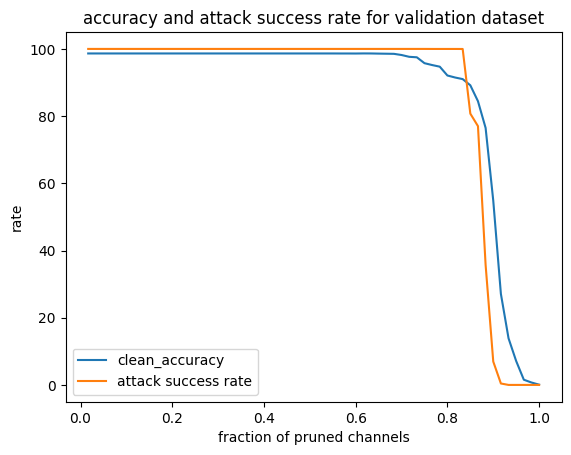

In [ ]:
#Plotting the accuracy and attack success rate for the validation dataset
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [ ]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


## Combining the models

Here we combine two models which are $B$ (original badnet model) and $B'$ (pruned model). The combined model is the *goodnet*. If the preditions from $B$ and $B'$ are the same then the *goodnet* will output the predition.

In [ ]:
class G(keras.Model):
    # Constructor method with initialization
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        # Initialize two model attributes, B and B_prime, with the provided models
        self.B = B
        self.B_prime = B_prime

    # Method for making predictions with the good model
    def predict(self, data):
        y = np.argmax(self.B(data), axis=1) # Predict the class labels using model B and select the class with the highest probability
        y_prime = np.argmax(self.B_prime(data), axis=1) # Predict the class labels using model B_prime in a similar way

        # Initialize an array to hold the final predictions
        pred = np.zeros(data.shape[0])

        # Iterate over each prediction
        for i in range(data.shape[0]):
            # If the predictions from both models match, use this prediction
            if y[i] == y_prime[i]:
                pred[i] = y[i]
            # If the predictions differ, assign a default class label (e.g., 1283)
            else:
                pred[i] = 1283

        # Return the final prediction array
        return pred


## Evaluate the combined model

In [ ]:
test_data_filename = '/content/drive/MyDrive/lab3/data/cl/test.h5'
poisoned_test_data_filename = '/content/drive/MyDrive/lab3/data/bd/bd_test.h5'
test_model_X_2_filename = '/content/model_X=2.h5'
test_model_X_4_filename = '/content/model_X=4.h5'
test_model_X_10_filename = '/content/model_X=10.h5'

In [ ]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [ ]:
# Loading the data and displaying the shape
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

In [ ]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [ ]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

### Evaluating model on the test dataset

In [ ]:
# Predicting labels for clean test data using the model saved after 2% accuracy drop
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
# Calculating the classification accuracy for clean test data
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data)) * 100
# Printing the accuracy for the model with a 2% accuracy drop
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

# Predicting labels for poisoned test data using the same model
bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
# Calculating the attack success rate for the poisoned data
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data)) * 100
# Printing the attack success rate for the 2% accuracy drop model
print('2% drops model, Attack Success Rate:', asr_2)

# Repeating the process for the model saved after a 4% accuracy drop
cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data)) * 100
print('4% drops model, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data)) * 100
print('4% drops model, Attack Success Rate:', asr_4)

# Repeating the process for the model saved after a 10% accuracy drop
cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data)) * 100
print('10% drops model, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data)) * 100
print('10% drops model, Attack Success Rate:', asr_10)


401/401 [==============================] - 1s 2ms/step
2% drops model, the clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 1s 2ms/step
2% drops model, Attack Success Rate: 100.0
401/401 [==============================] - 1s 2ms/step
4% drops model, the clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 1s 2ms/step
4% drops model, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 1s 3ms/step
10% drops model, the clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 1s 3ms/step
10% drops model, Attack Success Rate: 77.20966484801247


### Summary of the fixed models

In [ ]:
# Creating a list of test accuracies for different models
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]

# Creating a list of attack success rates for the same models
attack_rate = [asr_2, asr_4, asr_10]

# Constructing a dictionary to organize the data
data = {
    "test_acc": test_acc,          # Test accuracy for each model
    "attack_rate": attack_rate,    # Attack success rate for each model
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]  # Model identifiers
}

# Creating a DataFrame from the dictionary
df = pd.DataFrame(data)

# Setting the 'model' column as the index of the DataFrame
df.set_index('model')


,test_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


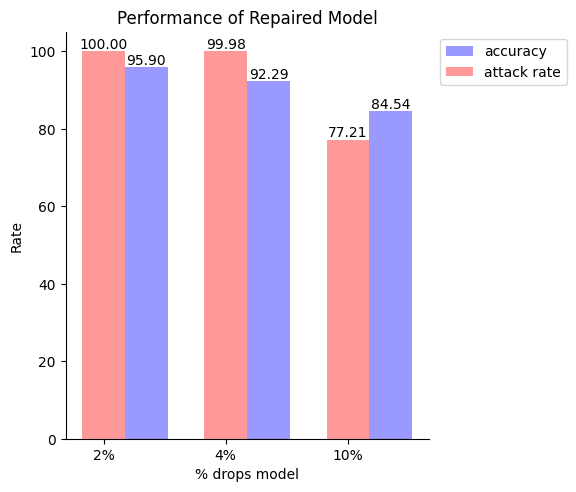

In [ ]:
# Setting the opacity and bar width for the bars in the bar chart
opacity = 0.4
bar_width = 0.35

# Set the label for the x and y axis
plt.xlabel('% drops model')
plt.ylabel('Rate')

# Set the x-ticks (positions) and labels (2%, 4%, 10%) on the x-axis
plt.xticks(range(len(test_acc)), ('2%', '4%', '10%'))

# Plotting the first set of bars (test accuracy) and second set of bars (attack rate)
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

# Loop to add text labels above each bar, indicating the height (value) of the bar
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

# Adding details for the plot
plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of Repaired Model')

# Remove the top and right spines for a cleaner look using seaborn's despine
sns.despine()

# Displaying the plot
plt.show()


These 'goodnets' represent a combination of the original badnet and the corrected or 'repaired' model.

In [ ]:
# Use the combined model with 2% drop to predict labels for clean test data
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
# Calculate and print the classification accuracy on clean test data for the 2% drop model
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data)) * 100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

# Use the same model to predict labels for poisoned test data
G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
# Calculate and print the attack success rate on poisoned data for the 2% drop model
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data)) * 100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

# Repeat the process for the combined model with 4% drop
G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data)) * 100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data)) * 100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

# Repeat the process for the combined model with 10% drop
G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data)) * 100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data)) * 100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)


Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [ ]:
# Creating a list containing the test accuracies for different combined models
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]

# Creating a list containing the attack success rates for the same combined models
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]

# Constructing a dictionary to organize the test accuracies, attack rates, and model names
G_data = {
    "G_text_acc": G_test_acc,             # Test accuracy for each combined model
    "G_attack_rate": G_attack_rate,       # Attack success rate for each combined model
    "G_model": ["G_2%", "G_4%", "G_10%"]  # Identifiers for each combined model
}

# Creating a DataFrame from the organized data
G_df = pd.DataFrame(G_data)

# Setting the 'G_model' column as the index of the DataFrame for better readability
G_df.set_index('G_model')


,G_text_acc,G_attack_rate
G_model,,
G_2%,95.900234,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.209665


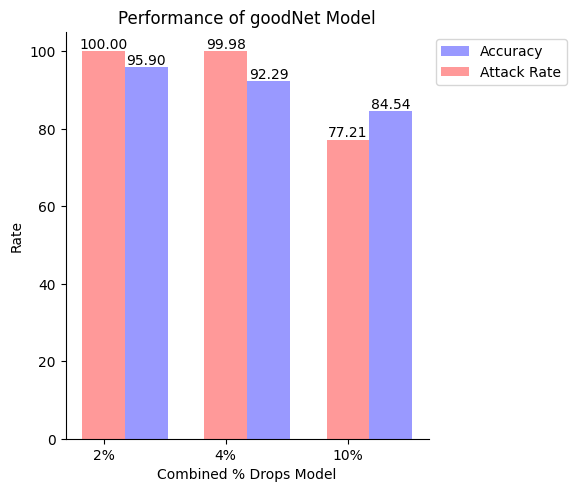

In [ ]:
# Set the opacity and bar_width for the bars in the bar chart
opacity = 0.4
bar_width = 0.35

# Set the label for the x and y-axis
plt.xlabel('Combined % Drops Model')
plt.ylabel('Rate')

# Define the x-ticks (positions) and labels (2%, 4%, 10%) on the x-axis
plt.xticks(range(len(G_test_acc)), ('2%', '4%', '10%'))

# Plotting the first set of bars (test accuracy) and second set of bars (attack rate) for the combined models
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='Accuracy')
bar2 = plt.bar(range(len(G_attack_rate)), G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='Attack Rate')

# Loop to add text labels above each bar, displaying the height (value) of the bar
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

# Adding plot details
plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of goodNet Model')
sns.despine()

# Display the final plot
plt.show()


---